# A/B 테스팅
- 웹사이트의 방문자를 임의로 두 집단으로 나누고, 한 집단에게는 기존 사이트를 보여주고 다른 집단에게는 새로운 사이트를 보여준 다음, 두 집단 중 어떤 집단이 더 높은 *성과를 보이는지를 측정하여 새 사이트가 기존 사이트에 비해 좋은지를 정량적으로 평가하는 방식을 말함.
- *성과: 회원 가입율, 재방문율, 구매 전환율 등 

# 상황설명
- Yammer의 publisher 기능개선을 위해 A/B test 진행 (6.1~6.30)
    - A그룹: be shown the old version of the publisher (control group - 대조군)
    - B그룹: be shown the new version of the publisher (treatment group - 실험군)

- 실험결과: treatment group의 message posting이 대조군에 비해 50% 높았다.


# 분석 준비
- 사용할 데이터: `Users`, `Events`, `Experiments`

In [1]:
# 테이블 로드
from load_table import *

load_csv('./yammers_data/yammer_experiments.csv', 'experiments')

In [2]:
# mysql 연결
from mysql_connector import *
connection = create_mysql_connection('localhost','CLOUDY','1234','yammers')

Connected to MySQL server : localhost


In [73]:
query_experiment = " SELECT * FROM experiments "
query_users = " SELECT * FROM users "
query_events = " SELECT * FROM events "
ex_df = pd.read_sql(query_experiment, connection)
user_df = pd.read_sql(query_users, connection)
event_df = pd.read_sql(query_events, connection)

ex_df

,user_id,occurred_at,experiment,experiment_group,location,device,user_type
0,4.0,2014-06-05 15:20:16,publisher_update,control_group,India,lenovo thinkpad,3.0
1,8198.0,2014-06-11 09:31:32,publisher_update,control_group,Japan,nokia lumia 635,1.0
2,11.0,2014-06-17 09:31:22,publisher_update,control_group,United States,iphone 4s,1.0
3,8209.0,2014-06-04 09:31:21,publisher_update,test_group,Turkey,nokia lumia 635,1.0
4,19.0,2014-06-04 09:31:33,publisher_update,test_group,Nigeria,iphone 5,1.0
...,...,...,...,...,...,...,...
2590,14327.0,2014-06-17 09:51:41,publisher_update,control_group,Korea,lenovo thinkpad,2.0
2591,14329.0,2014-06-17 07:28:56,publisher_update,control_group,United Kingdom,macbook air,1.0
2592,14330.0,2014-06-17 13:46:23,publisher_update,control_group,France,macbook pro,2.0
2593,14334.0,2014-06-17 23:51:01,publisher_update,control_group,Denmark,windows surface,3.0


In [328]:
user_df

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,None,pending
2,2.0,2013-01-01 10:59:05,51.0,english,None,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active
...,...,...,...,...,...,...
19061,19061.0,2014-08-31 13:21:16,2156.0,chinese,2014-08-31 13:22:50,active
19062,19062.0,2014-08-31 19:21:23,7520.0,spanish,None,pending
19063,19063.0,2014-08-31 07:10:41,72.0,spanish,2014-08-31 07:12:09,active
19064,19064.0,2014-08-31 17:45:18,2.0,english,None,pending


In [74]:
event_df

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0
...,...,...,...,...,...,...,...
340827,18815.0,2014-08-31 13:41:46,engagement,like_message,Ireland,dell inspiron notebook,2.0
340828,18815.0,2014-08-31 13:42:11,engagement,home_page,Ireland,dell inspiron notebook,2.0
340829,18815.0,2014-08-31 13:42:43,engagement,send_message,Ireland,dell inspiron notebook,2.0
340830,18815.0,2014-08-31 13:43:07,engagement,home_page,Ireland,dell inspiron notebook,2.0


In [329]:
event_df['event_type'].unique()

array(['engagement', 'signup_flow'], dtype=object)

# A/B 테스트 결과 확인

- users: control_group, test_group 각각에 포함된 user 수
- total_treated_users: 전체 실험군 (control + test group)
- treatment_percent: 전체 실험군 中 control_group에포함된 user 수 , test_group에 포함된 user 수
- total: 각 그룹유저들이 6월 한달동안 포스팅한 총 횟수
- average: total/users (1인당 평균 포스팅 수-> test group: 4.07회, control group: 2.6..회 -> test group이 50% 더 많음)

- test group의 평균 메시지 발송 수가 control group 보다 50% 이상 많음
- test group과 control group 사이에 지표 차이가 나는 것은 좋지만... 왜 이렇게까지 많이 차이가 날까? 1.5배 차이라니?
- message send 기능이 아무리 좋게 개선되었다고 하더라도 왜 이렇게까지..?
  1. metric이 프로젝트의 성공여부를 반영하지 못할 수도 있다.즉, 보낸 메시지의 수(posting rate)가 UI 개선 프로젝트의 성공을 측정하는 지표가 아닐 수도 있다. 다른 지표도 함께 살펴보아야 한다.
  2. 단순히 수학계산이 잘못 되었을 수도 있다. 
  3. Group이 제대로 나뉘지 않았을 수도 있다. Randomly하게 실험군, 대조군을 나누어야 하는데 랜덤하지 못했다거나. 예를 들면, 실험군:여자/대조군:남자로 나뉘거나, 실험군: 20대까지/대조군:30대 이상으로 연령대가 나뉘거나.. 이때 X는 publisher version, Y는  posting rates여야하는데, Y에 영향을 미치는 것이 X이외에 다른 것이 있다면 실험이 잘못된 것이다. 
   

In [336]:
query = " SELECT  experiment_group, COUNT(DISTINCT ex.user_id) user_cnt, \
                    COUNT(CASE WHEN event_name = 'send_message' THEN ex.user_id ELSE NULL END) as metric,\
                    COUNT(CASE WHEN event_name = 'send_message' THEN ex.user_id ELSE NULL END) / COUNT(DISTINCT ex.user_id) as average \
            FROM experiments ex \
                JOIN users u ON ex.user_id = u.user_id \
                JOIN events e on ex.user_id = e.user_id \
                AND ex.experiment = 'publisher_update' \
                AND e.occurred_at LIKE '%2014-06%' \
                AND e.event_type = 'engagement'  \
            GROUP BY experiment_group"

message_cnt_df = pd.read_sql(query, connection)
message_cnt_df

,experiment_group,user_cnt,metric,average
0,control_group,1746,4660,2.6690
1,test_group,849,3460,4.0754


C:\Users\TEMP\AppData\Local\Temp\ipykernel_22316\1730196465.py:13: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),


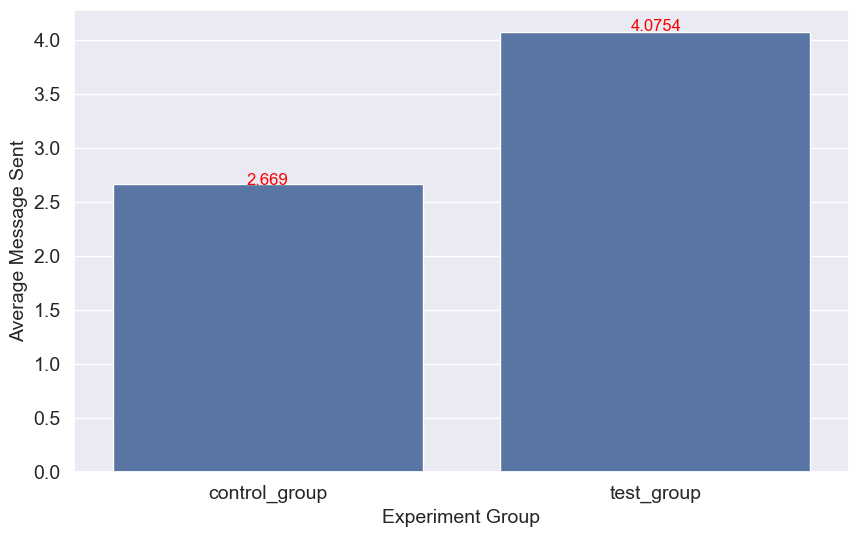

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.set_theme(palette='deep')
ax = sns.barplot(data=message_cnt_df, x='experiment_group', y='average')
plt.xlabel('Experiment Group',fontsize=14)
plt.ylabel('Average Message Sent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),
                fontsize=12,color='red', ha='center',va='center', textcoords='offset points')


plt.show()

## Mission
- Test group과 Control group의 average message sent 수가 50% 이상 차이가 나는 이유 에 대해 조사해보자

# 분석1. 로그인 지표 분석
- A/B test의 성공을 나타내는지표는 posting rates 외에도 다른 지표가 존재할 수 있다. 다른 지표들을 살펴보자.
- Publisher 개선의 성공은 `User의 login 빈도 수` 와 연관이 있지 않을까?
- `User의 평균 login 수` 를 알아보자.       

### 로그인 횟수

In [351]:
query = " SELECT  experiment_group, COUNT(DISTINCT ex.user_id) user_cnt, COUNT(CASE WHEN event_name ='login' THEN ex.user_id ELSE NULL END) as login_cnt, \
                COUNT(CASE WHEN event_name ='login' THEN ex.user_id ELSE NULL END)/ COUNT(DISTINCT ex.user_id) average \
            FROM experiments ex \
                JOIN users u ON ex.user_id = u.user_id \
                JOIN events e on ex.user_id = e.user_id \
                AND ex.experiment = 'publisher_update' \
                AND e.occurred_at LIKE '%2014-06%' \
                AND e.event_type = 'engagement'   \
            GROUP BY experiment_group"

login_cnt_df = pd.read_sql(query, connection)
login_cnt_df

,experiment_group,user_cnt,login_cnt,average
0,control_group,1746,5789,3.3156
1,test_group,849,3481,4.1001


C:\Users\TEMP\AppData\Local\Temp\ipykernel_22316\3721714185.py:3: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),


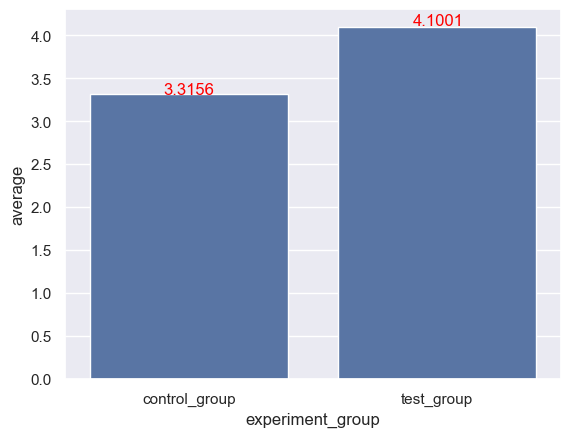

In [352]:
ax = sns.barplot(data= login_cnt_df, x='experiment_group', y='average')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),
                fontsize=12,color='red', ha='center',va='center', textcoords='offset points')

- 평균 로그인 수는 대조군이 평균 3.3번, 실험군이 평균 4.1번으로 실험기간 중 평균 로그인 수도 실험군이 더 높다.
- 즉, test group의 유저들은 한 달 동안 평균 4.1회, control group의 유저들은 한 달 동안 평균 3.3회 로그인 함. 

### 로그인 일수 (몇 일 들어왔는가?)
- 로그인은 많이 하고있으나 로그인 한 날수를 세봤더니 별로 차이가 나지 않는다면...그냥 하루에 로그인-로그아웃 반복을 많이하고 있다는 소리. 이는 좋은 시그널이 아님. 

In [355]:
query = " SELECT experiment_group, avg(day) as login_day_avg \
            FROM \
                (SELECT experiment_group, e.user_id, COUNT(DISTINCT DATE_FORMAT(e.occurred_at, '%Y-%m-%d')) as day \
                    FROM experiments ex \
                        JOIN users u ON ex.user_id = u.user_id \
                        JOIN events e on ex.user_id = e.user_id \
                        AND ex.experiment = 'publisher_update' \
                        AND e.occurred_at LIKE '%2014-06%' \
                        AND e.event_type = 'engagement'   \
                    GROUP BY experiment_group, e.user_id) a \
            GROUP BY 1"

login_day_df = pd.read_sql(query, connection)
login_day_df

,experiment_group,login_day_avg
0,control_group,3.0338
1,test_group,3.6031


C:\Users\TEMP\AppData\Local\Temp\ipykernel_22316\2457649385.py:3: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax2.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),


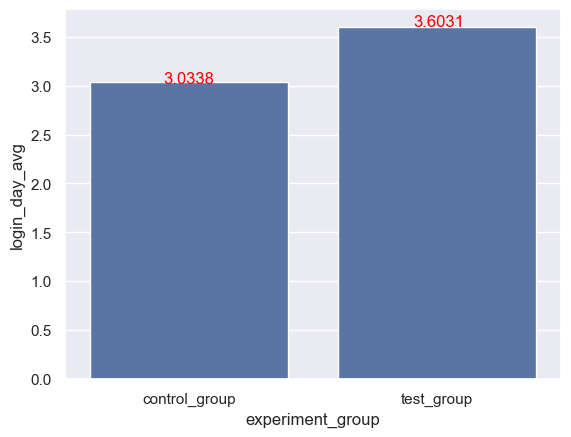

In [356]:
ax2= sns.barplot(data = login_day_df, x='experiment_group', y='login_day_avg')
for p in ax2.patches:
    ax2.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),
                fontsize=12,color='red', ha='center',va='center', textcoords='offset points')



- test group의 유저들은 한 달 동안 평균 3일, control group의 유저들은 한 달 동안 평균 3.6일 로그인 함. 

분석1 결론
- 실험 기간 동안에 control group과 test group의 평균 로그인 횟수, 평균 로그인 일수를 계산해봤더니 모두 control < test group
- 실험 기간동안 실험군이 대조군 대비 유저 당 평균 0.8회 더 많이 로그인 했다. 
- 실험 기간동안 실험군이 대조군 대비 유저 당 평균 0.6일 더 많이 로그인 했다.

# 분석2.샘플링 공정성 확인

- Test/Control group을 나눌 때 과연 샘플링이 공정하게 되었을까?


In [359]:
query = " SELECT DATE_FORMAT(u.activated_at, '%Y-%m') as month_activated,   \
                COUNT(CASE WHEN e.experiment_group = 'control_group' THEN u.user_id ELSE NULL END) as control_users, \
                COUNT(CASE WHEN e.experiment_group = 'test_group' THEN u.user_id ELSE NULL END) as test_users \
            FROM experiments e \
            JOIN users u \
                ON e.user_id = u.user_id \
            GROUP BY 1 \
            ORDER BY 1"

sampling_df = pd.read_sql(query, connection)
sampling_df

,month_activated,control_users,test_users
0,2013-01,24,13
1,2013-02,27,20
2,2013-03,15,32
3,2013-04,28,27
4,2013-05,15,30
5,2013-06,22,19
6,2013-07,32,32
7,2013-08,41,38
8,2013-09,37,45
9,2013-10,46,45


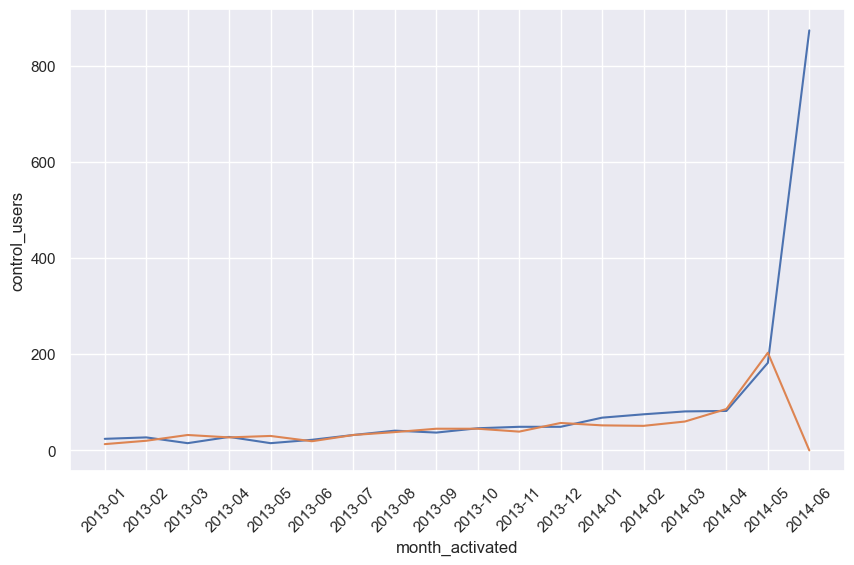

In [360]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sampling_df, x='month_activated', y='control_users')
sns.lineplot(data=sampling_df, x='month_activated', y='test_users')
plt.xticks(rotation=45)
plt.show()

- 2014.06월에 가입한 user들은 모두 control group에 포함되어 있다.
  - A/B test를 실행한 6월에 가입한 user들은 이전에 가입한 user들에 비해 로그인, 메시지 발송 등 활동할 기회가 적다. (활동기간이 촉박하기 때문)
  - 그래서 6월 가입자들의 로그인 지표, 활동 지표는 낮은게 당연
  - 그런데 이러한 6월 가입자들이 모두 control group에 포함되어 있다. 이러한 이유로 control user group의 성과 지표가 좋지 않게 나온 것일 수도 있다.

# 분석3. 6월 가입자들을 제외하고 다시 분석

In [327]:
query = " SELECT  experiment_group, COUNT(DISTINCT ex.user_id) user_cnt, \
                    COUNT(CASE WHEN event_name = 'send_message' THEN ex.user_id ELSE NULL END) as metric,\
                    COUNT(CASE WHEN event_name = 'send_message' THEN ex.user_id ELSE NULL END) / COUNT(DISTINCT ex.user_id) as average \
            FROM experiments ex \
                JOIN users u ON ex.user_id = u.user_id \
                JOIN events e on ex.user_id = e.user_id \
                AND ex.experiment = 'publisher_update' \
                AND e.occurred_at >= ex.occurred_at \
                AND e.occurred_at < '2014-07' \
                AND e.event_type = 'engagement' \
                AND u.activated_at NOT LIKE '%2014-06%' \
            GROUP BY experiment_group"

mod2_df = pd.read_sql(query, connection)
mod2_df

,experiment_group,user_cnt,metric,average
0,control_group,873,2546,2.9164
1,test_group,849,3460,4.0754


C:\Users\TEMP\AppData\Local\Temp\ipykernel_22316\3130435030.py:3: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax3.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),


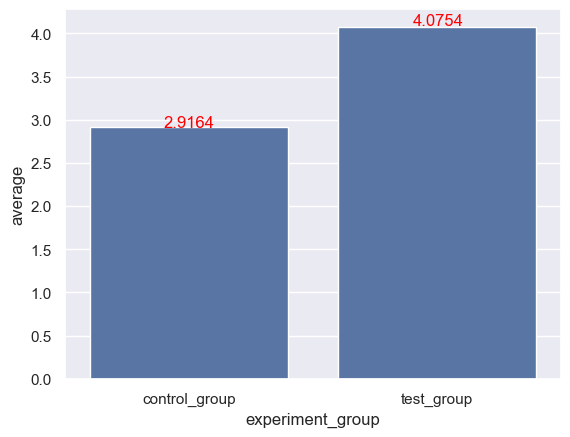

In [326]:
ax3 = sns.barplot(data=mod2_df, x='experiment_group',y='average')
for p in ax3.patches:
    ax3.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()),
                fontsize=12,color='red', ha='center',va='center', textcoords='offset points')



- control group에서 6월에 가입한 user들을 제외했더니 2.6 -> 2.9로 Average Message Sent 수가 증가했고, 실험군과 대조군의 차이는 적어짐.
- 차이가 적어졌지만 여전히 test group의 평균 메시지 전송수가 더 많다.